# Jupyter Notebook

The code in this notebook is designed to assist with the analysis of data collected to tune free parameters for the UREC carbon capture device. Currently, the code produces dummy data for all of the free parameters, and the output of interest from the device is assumed to be the measured CO<sub>2</sub> concentration (in ppm) of the air coming out of the device. 

**Important Note:** I'm very much not an expert on the DACC process or the device constructed by the UREC team! I just like writing analysis code and making pretty plots :)
If anything about any of the variables here, or their units, ranges, etc. seems confusing or off, please just let me know and I'll try to improve things to make the analysis more representative of the actual setup and data-taking process. 

Having said that, I'm trying to keep the code as general as possible to allow for parameters to be easily added or removed from the analysis on-the-fly.

Currently, the code considers the following free parameters:

* **Basket configuration:** It's currently assumed that several different basket configurations will be tested. The different configurations can just be labelled as unique strings (eg. `config_1`, `config_2`, etc.)
* **Spray duration (s):** The length of time that water is sprayed continuously onto the sorbent 
* **Spray interval (s):** The time interval between continuous sprays (i.e. between the beginning of one spray and the beginning of the next one). 
* **Fan on time (s):** The length of time that the fan is on in between sprays (**This is my understanding of what this variable means, but please correct me if wrong!!**)
* **Exposed surface area (cm<sup>2</sup>):** The measured surface area of sorbent explosed to the fan. 

<hr>

## Bokeh Imports

The python cell below performs standard imports for the bokeh package used for data visualization. 

In [1]:
# Standard imports for bokeh visualization package
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

## Making Dummy Data

The following cell makes dummy data for the CO<sub>2</sub> concentration and free parameters listed above. 

**Important note:** When working with actual data from the DACC machine, there will be no need to produce dummy data, so the following cell will not need to be run! Instead, the data will be read in as a csv file, which I anticipate would be exported from an excel spreadsheet. 

### Data Samples

Five basket configurations are considered, currenly labelled `{'config_1', 'config_2', ..., 'config_5'}`. For each of the other free parameters, 10 sample values are tested within a specified range. I then consider all possible combinations of the sample values for all the free parameters to form a complete set of samples. 

I also add some random jitter to the sample locations, to reflect the fact that the sample values tested in practice are unlikely to follow a perfect grid. 

### Multi-dimensional Gaussian Function for CO$_2$ Concentration

Not knowing what the actual data will look like, the CO<sub>2</sub> concentration is constructed to follow a multi-dimensional Gaussian shape as a function of the free parameters, with a peak somewhere within the tested ranges of each free parameters.

The multi-dimensional Gaussian of $n$ dimensions is defined as:

$$f(x_1, ... x_n) = Ae^{-\big[(x_1-\mu_1)^2/(2\sigma_1)^2 + ... + (x_n-\mu_n)^2/(2\sigma_n)^2\big]}$$

where for a given free parameter $x_i$, the $\mu_i$ and $\sigma_i$ represent the central value and width, respectively, of the Gaussian peak in that parameter,  For simplicity, I'm setting A to 1 for the dummy data, since the scaling isn't too important. 

For a given variable $x_i$, I consider several different central values $\mu_i$ for the Gaussian peak, depending on the basket configuration, but they're all located within the range of tested values. The peak width $\sigma_i$ is set to 1/4 of the range of tested values: $\sigma_i = \frac{1}{4}\big(\max\{x_{i, \text{tested}}\} - \min\{x_{i, \text{tested}}\}\big)\}$.

In [2]:
############################################# Making dummy data #################################################

# Import numpy for array construction and manipulation
import numpy as np

# Make arrays of dummy data for spray duration, spray frequency, and basket configuration.
#### For the dummy data, five basket configurations are tested, labelled "config_#"".
spray_duration = np.linspace(1, 10, 5)
spray_interval = np.linspace(10, 60, 5)
fan_on_time = np.linspace(10, 60, 5)
exposed_surface_area = np.linspace(1, 10, 5)
basket_configs = ['config_1', 'config_2', 'config_3', 'config_4', 'config_5']
basket_config_indices = 1 + np.arange(len(basket_configs))

# Make a mesh of the tuned variables that covers all combinations of spray intervals and durations
spray_duration_mesh, spray_interval_mesh, \
fan_on_time_mesh, exposed_surface_area_mesh = np.meshgrid(spray_duration, spray_interval, 
                                                          fan_on_time, exposed_surface_area) 

# Flatten the arrays of all variables to make 1D arrays with all combinations
spray_duration = spray_duration_mesh.ravel()
spray_interval = spray_interval_mesh.ravel()
fan_on_time = fan_on_time_mesh.ravel()
exposed_surface_area = exposed_surface_area_mesh.ravel()

# For each configuration tested, add some jitter to randomize the spray durations and intervals a bit
spray_durations = {}
spray_intervals = {}
fan_on_times = {}
exposed_surface_areas = {}
for config in basket_configs:
    spray_durations[config] = spray_duration + (np.random.rand(len(spray_duration))-0.5) * \
                                                              0.5 * ( max(spray_duration) - min(spray_duration) )
    spray_intervals[config] = spray_interval + (np.random.rand(len(spray_interval))-0.5) * \
                                                              0.5 * ( max(spray_interval) - min(spray_interval) )
    fan_on_times[config] = fan_on_time + (np.random.rand(len(fan_on_time))-0.5) * \
                                                              0.5 * ( max(fan_on_time) - min(fan_on_time) )
    exposed_surface_areas[config] = exposed_surface_area + (np.random.rand(len(exposed_surface_area))-0.5) * \
                                                              0.5 * ( max(exposed_surface_area) - min(exposed_surface_area) )

###### Construct dummy data for the CO2 ppm as multi-dimensional Gaussian functions of spray interval and spray duration. ######
# For each basket configuration, set a different peak location of the Gaussian function in spray duration and interval 
spray_duration_peaks = min(spray_duration) + basket_config_indices * \
                       ( max(spray_duration) - min(spray_duration) ) / (len(basket_config_indices) + 1.)
spray_interval_peaks = min(spray_interval) + basket_config_indices * \
                       ( max(spray_interval) - min(spray_interval) ) / (len(basket_config_indices) + 1.)
fan_on_time_peaks = min(fan_on_time) + basket_config_indices * \
                       ( max(fan_on_time) - min(fan_on_time) ) / (len(basket_config_indices) + 1.)
exposed_surface_area_peaks = min(exposed_surface_area) + basket_config_indices * \
                       ( max(exposed_surface_area) - min(exposed_surface_area) ) / (len(basket_config_indices) + 1.)

# Set the widths of the dummy spray duration and interval Gaussian peaks to 1/4 their total measured range
spray_duration_width = ( max(spray_duration) - min(spray_duration) ) / 4.
spray_interval_width = ( max(spray_interval) - min(spray_interval) ) / 4.
fan_on_time_width = ( max(fan_on_time) - min(fan_on_time) ) / 4.
exposed_surface_area_width = ( max(exposed_surface_area) - min(exposed_surface_area) ) / 4.

# Make the dummy multidimensional Gaussian functions for each configuration
CO2_ppms = {}
for i in range(len(basket_configs)):
    CO2_ppms[basket_configs[i]] = np.exp(-( \
                                            (spray_durations[basket_configs[i]] - spray_duration_peaks[i])**2 \
                                            / (2 * (spray_duration_width)**2) + \
                                            (spray_intervals[basket_configs[i]] - spray_interval_peaks[i])**2 \
                                            / (2 * (spray_interval_width)**2) + \
                                            (fan_on_times[basket_configs[i]] - fan_on_time_peaks[i])**2 \
                                            / (2 * (fan_on_time_width)**2) + \
                                            (exposed_surface_areas[basket_configs[i]] - exposed_surface_area_peaks[i])**2 \
                                            / (2 * (exposed_surface_area_width)**2) \
                                          ) \
                                        )

## Saving the Dummy Data to a CSV File

The next cell saves the dummy data produced in the previous cell to a CSV (comma-separated-value) file. 

As with the previous cell, this will not need to be run when using actual data from the DACC machine, since in that case the CSV file will be exported from excel and read in directly.

In [3]:
# Organize the data into a dictionary, with one key per variable, to make it easy to export to csv
data_to_export = {
    'configs': [],
    'spray duration': np.zeros(0),
    'spray interval': np.zeros(0),
    'fan on time': np.zeros(0),
    'exposed surface area': np.zeros(0),
    'CO2 ppm': np.zeros(0)
}

# Populate the dictionary with the dummy data, looping over all basket configurations
for this_config in basket_configs:
    data_to_export['configs'] += [this_config] * len(spray_durations[this_config])  # This makes a list of identical strings
    data_to_export['spray duration'] = np.append(data_to_export['spray duration'], spray_durations[this_config])
    data_to_export['spray interval'] = np.append(data_to_export['spray interval'], spray_intervals[this_config])
    data_to_export['fan on time'] = np.append(data_to_export['fan on time'], fan_on_times[this_config])
    data_to_export['exposed surface area'] = np.append(data_to_export['exposed surface area'], exposed_surface_areas[this_config])
    data_to_export['CO2 ppm'] = np.append(data_to_export['CO2 ppm'], CO2_ppms[this_config])
    
# Save the dictionary to a CSV file
import csv
out_file = open('dummy_data.csv', 'w')
writer = csv.DictWriter(out_file, data_to_export.keys(), dialect = 'excel')

writer.writeheader()
for i in range(len(list(data_to_export.values())[0])):
        writer.writerow({key:data_to_export[key][i] for key in data_to_export.keys()}) 

## Reading in the CSV Data

The next cell reads in the CSV data as a python dictionary for analysis. If working with real data, you will need to update the name of the CSV file that gets read in.

In [4]:
# Read in the CSV file. 
import csv 
import collections
import pandas as pd

## UPDATE FILENAME 'dummy_data.csv' AS NEEDED! ##
input_data_pd = pd.read_csv('dummy_data.csv')
#print(input_data_pd)

## Visualizing the Data

The next cell visualizes the CO<sub>2</sub> concentration (assumed to be measured in ppm) as a 2D colour map, for all combinations of variables tuned (one such variable will be shown on the x-axis, and the other on the y-axis). 

For each 2D plot, the basket configurations tested can be varied interacting by pressing the button corresponding to the desired basket configuration. 

Please note that some assumptions are made regarding the naming of headers in the csv file. Specifically, it's assumed that:

* There is exactly one column containing the CO<sub>2</sub> concentrations, and the name of the column header contains at least one of the following two keywords: 'CO2' and 'ppm'
* There is exactly one column containing the basket configurations, and the name of the column header contains the keyword 'onfig' (thus allowing for either 'config' or 'Config'). 

In [31]:
#### This cell uses the bokeh package to visualize the CO2 ppm as a function of spray frequency and duration #####

# Import packages for model construction and plotting
from bokeh.plotting import figure
from bokeh.models import LinearColorMapper
from bokeh.models import ColumnDataSource
from bokeh.layouts import column, row
from bokeh.models import ColorBar
from bokeh.models import CustomJS, RadioButtonGroup

# Obtain the configuration names ### IMPORTANT: this assumes that they're saved in a column whose header contains
# the keyword 'onfig'! The code will return an error and quit either if no columns contain this keyword, 
# or if more than one does ###
configs_names = []
for key in input_data_pd:
    if 'onfig' in key:
        configs_names.append(key)
        
if len(configs_names) == 0:
    print("ERROR: Expect one column for 'basket configurations' containing the keyword 'onfig', but found none! Exiting.")
    exit(1)
elif len(configs_names) > 1:
    print("ERROR: Expect one column for 'basket configurations' containing the keyword 'onfig', but found more than one! Exiting.")
    exit(1)

config_name = configs_names[0]

basket_configs = list(set(input_data_pd['configs']))

# Sort config names so they're in alphabetical order
basket_configs.sort()

# Assume the column name with the CO2 concentration in ppm will contain either 'CO2' or 'ppm' - the code will 
# return an error and quit either if no columns contain either of these, or if more than one does
CO2_ppm_keys = []
for key in input_data_pd:
    if 'CO2' in key or 'ppm' in key:
        CO2_ppm_keys.append(key)

if len(CO2_ppm_keys) == 0:
    print("ERROR: Expect one column for 'CO2 (ppm)' containing either 'CO2' or 'ppm', but found none! Exiting.")
    exit(1)
elif len(CO2_ppm_keys) > 1:
    print("ERROR: Expect one column for 'CO2 (ppm) containing either 'CO2' or 'ppm', but found more than one! Exiting.")

CO2_ppm_key = CO2_ppm_keys[0]
    
# Function to a 2D colour map of CO2 ppm as a function of two other variables for all basket configs
def make_co2_colour_map(var1, var2):
    
    iconfig=0
    config = basket_configs[iconfig]
    
    # Start by making dictionaries of data to be plotted for each config (this will be needed for the interactive
    # display)
    var1_data_dict = {}
    var2_data_dict = {}
    CO2_data_dict = {}
    for this_config in basket_configs:
        
        data_pd_config = input_data_pd[input_data_pd["configs"] == this_config]
        var1_data_dict[this_config] = list(data_pd_config[var1].astype(float))
        var2_data_dict[this_config] = list(data_pd_config[var2].astype(float))
        CO2_data_dict[this_config] = list(data_pd_config[CO2_ppm_key].astype(float))
        
    # Select the first config for the initial plot
    var1_data = var1_data_dict[config]
    var2_data = var2_data_dict[config]
    CO2_data = CO2_data_dict[config]

    # Prepare the data to be plotted, setting the colours of the points to be plotted according to the CO2 ppm
    source = ColumnDataSource(data = dict(var1_plot = var1_data, var2_plot = var2_data, colour = CO2_data))

    # Map the CO2 ppms onto a colour gradient
    exp_cmap = LinearColorMapper(palette="Viridis256", 
                                 low = min(CO2_data), 
                                 high = max(CO2_data))

    # Plot as a scatter plot, with the location of each point corresponding to the spray duration and frequency 
    # and the colour corresponding to the measured CO2 ppm
    p = figure(width=400, height=400, title="CO2 (ppm)")
    p.circle('var1_plot', 'var2_plot', size=10, source=source, line_color=None,
        fill_color={"field":"colour", "transform":exp_cmap})
    p.xaxis.axis_label = var1
    p.yaxis.axis_label = var2

    # Plot the colour bar
    bar = ColorBar(color_mapper=exp_cmap, location=(0,0))
    p.add_layout(bar, "left")
    
    # Make a button group to update the CO2 ppm in the plot according to the configuration tested
    button_group = RadioButtonGroup(labels=basket_configs, active=0)
    update_button = CustomJS(args=dict(basket_configs=basket_configs, var1_data_dict=var1_data_dict, 
                                       var2_data_dict=var2_data_dict, CO2_data_dict=CO2_data_dict,
                                       source=source), code="""
                                       console.log('radio_button_group: active=' + this.active)
                                       const var1_plot = var1_data_dict[basket_configs[this.active]]
                                       const var2_plot = var2_data_dict[basket_configs[this.active]]
                                       const colour = CO2_data_dict[basket_configs[this.active]]
                                       source.data = { var1_plot, var2_plot, colour }
                                       """
                            )

    # Update the plot any time a button is clicked
    button_group.js_on_click(update_button)

    # Display the buttons and plot in one column 
    show(column(button_group,p))

# Go through all variables other than the basket configuration and the CO2 concentration (ppm), and plot the CO2 
# concentration as a 2D colour map for all basket configs, with all possible combinations of the remaining variables
# on the x an y axes
variables = list(input_data_pd.keys())
for key in [config_name, CO2_ppm_key]:
    variables.remove(key)

for i in range(len(variables)):
    for j in range(i):
        make_co2_colour_map(variables[i], variables[j])
            

## 3D Plots
The following cell interpolates the above scatter plots and visualizes them as 3D plots. 

Unfortunately the bokeh package used to interactively switch between different basket configurations in the above plots doesn't support 3D plotting, so instead this cell just dumps out the plots for each basket configuration and variable pair.

/var/folders/y9/9sz84f6566jb1_t36340bdsr0000gq/T/ipykernel_66748/1212882721.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7,7))


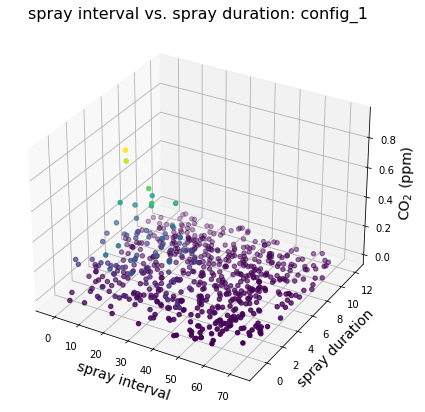

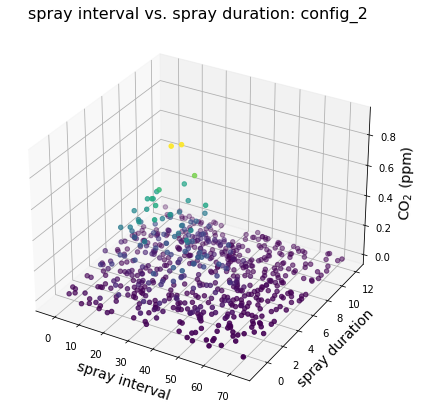

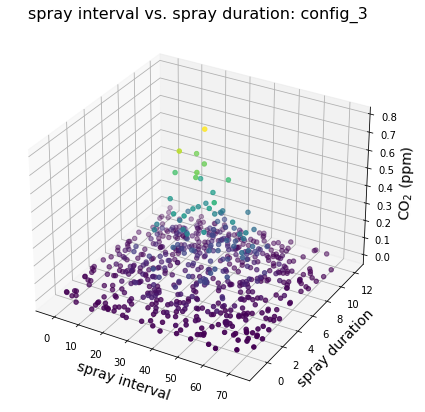

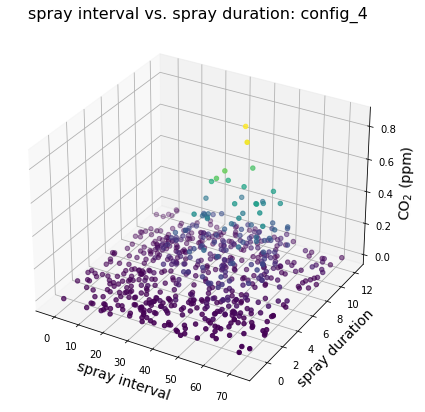

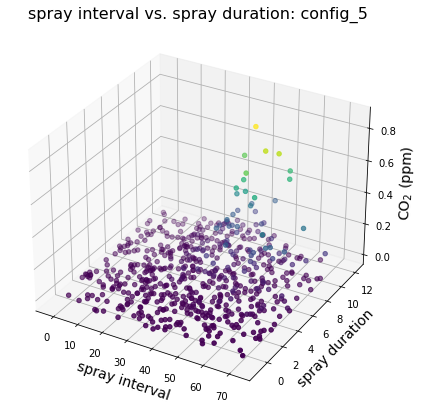

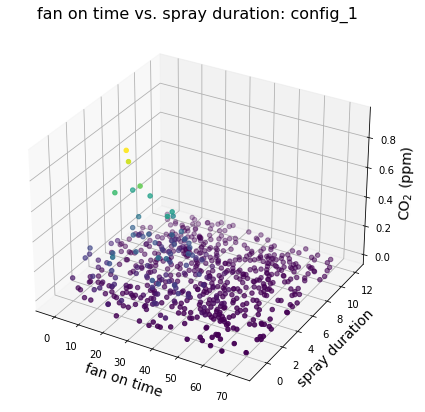

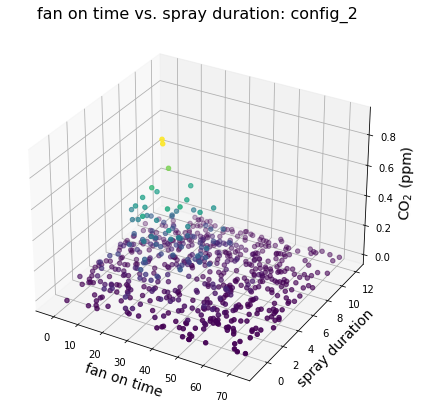

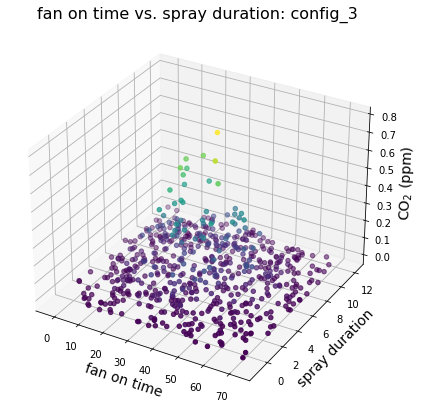

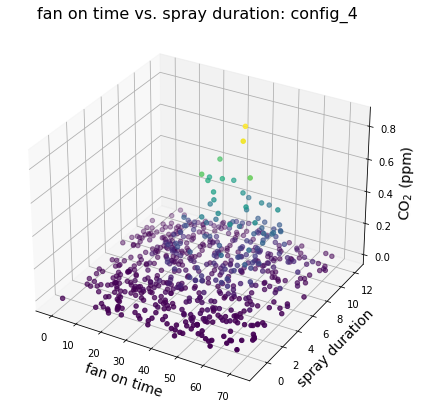

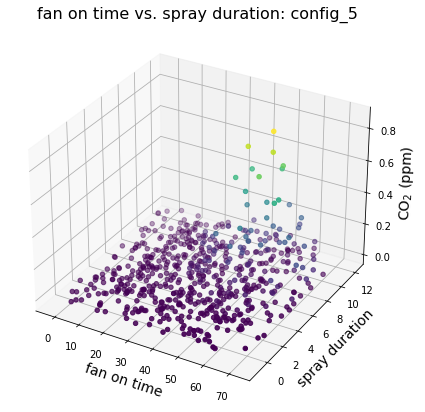

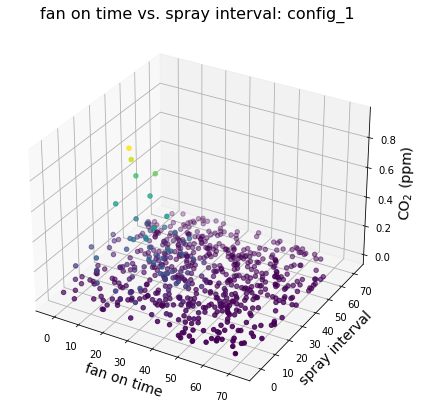

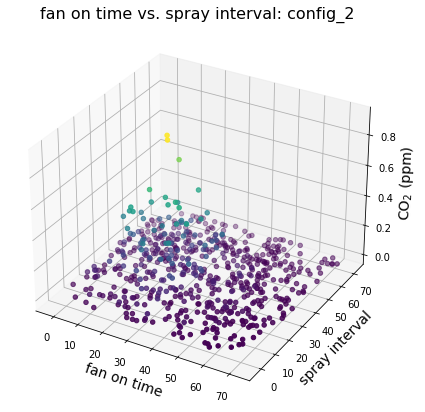

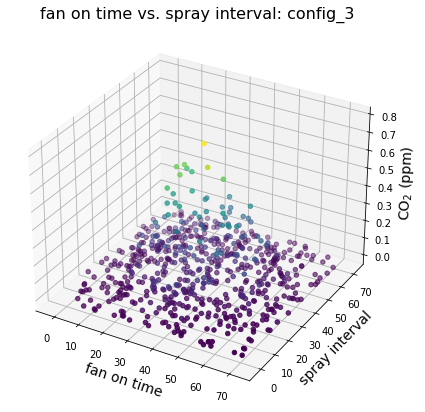

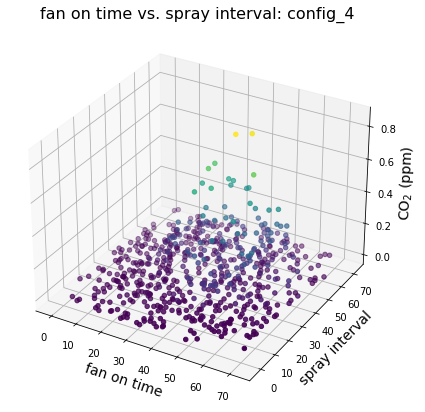

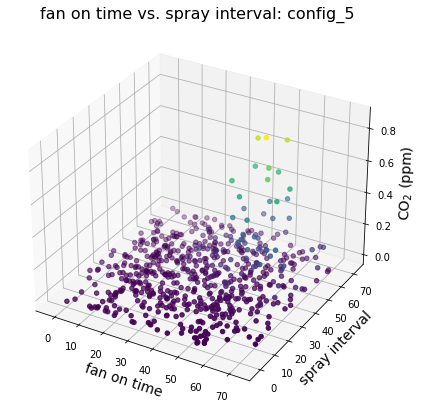

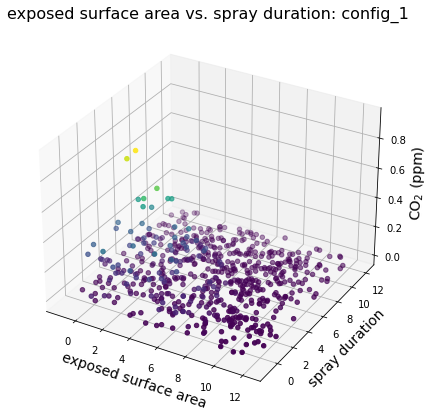

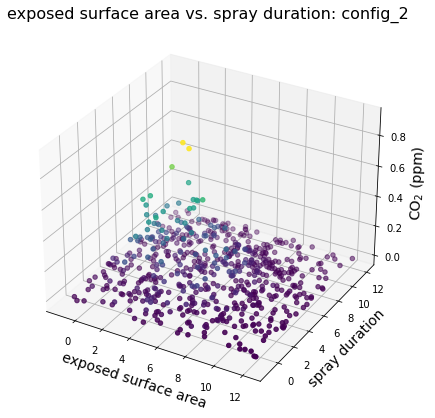

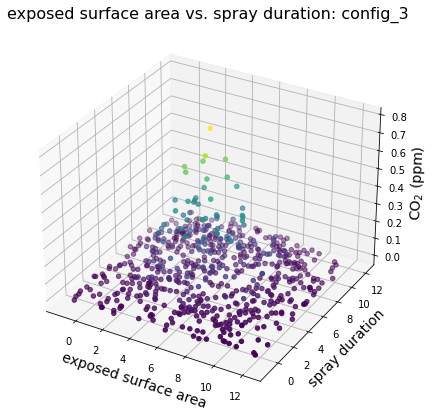

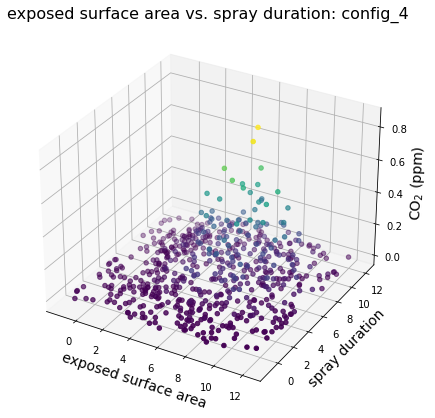

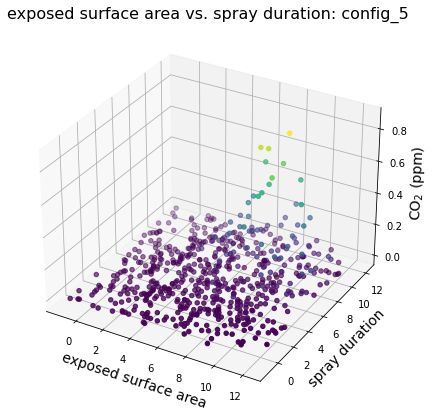

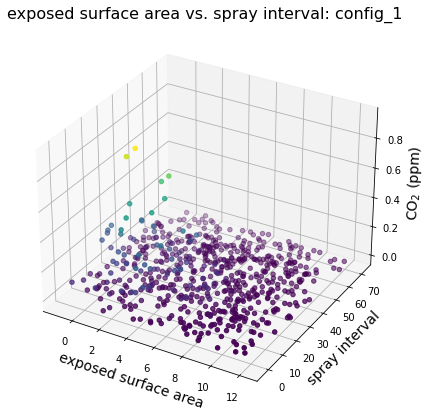

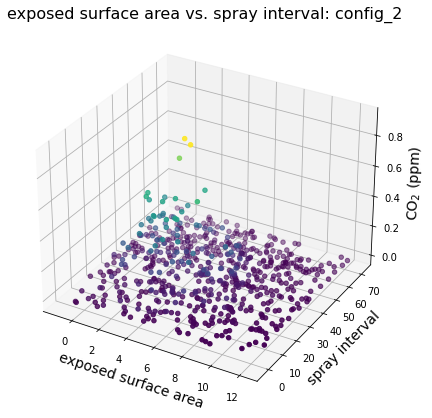

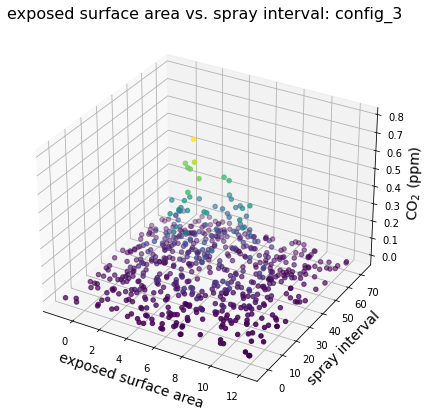

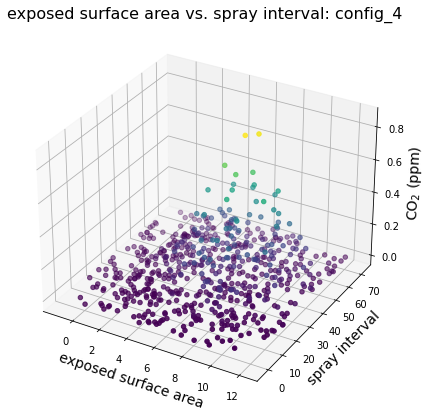

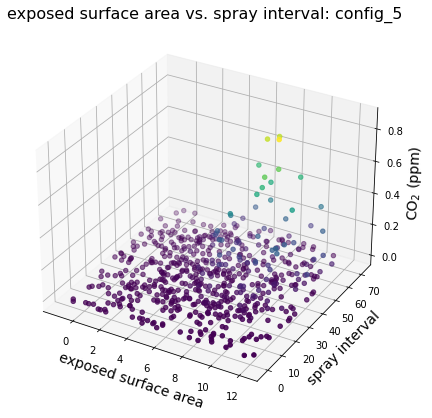

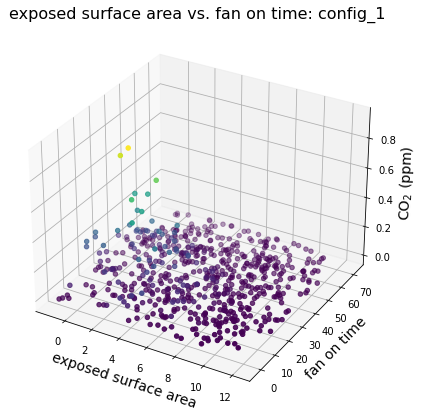

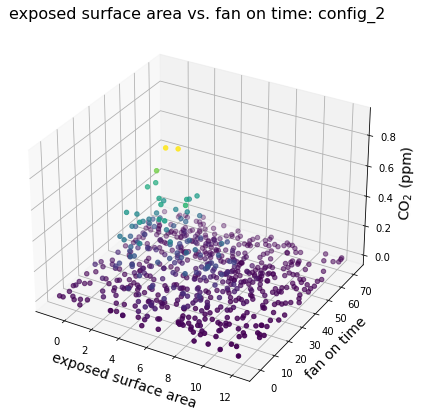

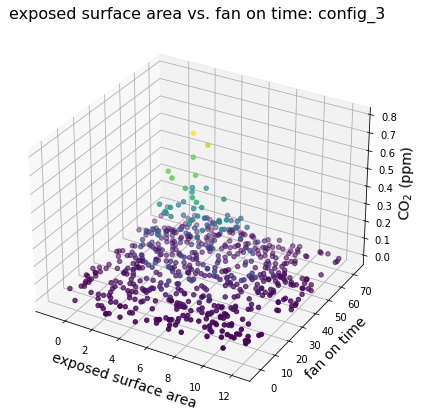

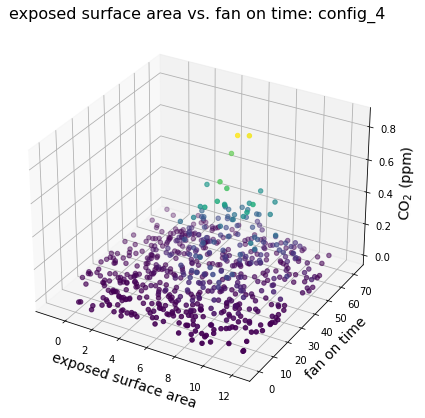

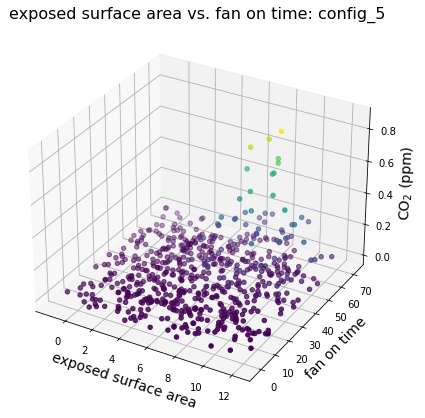

In [56]:
import matplotlib.pyplot as plt
import math

# Function to a 3D colour map of CO2 ppm as a function of two other variables for a given basket config
def make_co2_colour_map_3D(var1, var2, config):

    data_pd_config = input_data_pd[input_data_pd["configs"] == config]
    var1_data = list(data_pd_config[var1].astype(float))
    var2_data = list(data_pd_config[var2].astype(float))
    CO2_data = list(data_pd_config[CO2_ppm_key].astype(float))

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('%s vs. %s: %s'%(var1, var2, config), size=16)
    ax.set_xlabel(var1, size=14)
    ax.set_ylabel(var2, size=14)
    ax.set_zlabel('CO$_2$ (ppm)', size=14)
    ax.scatter(var1_data, var2_data, CO2_data, c=CO2_data, cmap="viridis")
        
for i in range(len(variables)):
    for j in range(i):
        for this_config in basket_configs:
            make_co2_colour_map_3D(variables[i], variables[j], this_config)